<a href="https://colab.research.google.com/github/michalmac89/cs230finalproject/blob/main/DenseNet_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DenseNet121
Next, we will use a pre-trained DenseNet121 model which we can load directly from PyTorch and then add two layers on top of it:


1.   A GlobalAveragePooling2D layer to get the average of the last convolution layers from DenseNet121.

2.   A Dense layer with sigmoid activation to get the prediction logits for each of our classes.


We can set our custom loss function for the model by specifying the loss parameter in the compile() function.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%matplotlib inline

import os
import torch
import random
import torchvision
import numpy as np
import pandas as pd

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

In [3]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x[-3:].lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['normal', 'viral', 'covid']
        
        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    
    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])
    
    
    def __getitem__(self, index):
        all_images = self.images[self.class_names[0]] \
          + self.images[self.class_names[1]] \
          + self.images[self.class_names[2]]
        all_class_names = [self.class_names[0]]*len(self.images[self.class_names[0]]) \
          + [self.class_names[1]]*len(self.images[self.class_names[1]]) \
          + [self.class_names[2]]*len(self.images[self.class_names[2]])
        image_name = all_images[index]
        class_name = all_class_names[index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

In [4]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
train_dirs = {
    'normal': 'drive/My Drive/dataset/COVID-19 Radiography Database/normal',
    'viral': 'drive/My Drive/dataset/COVID-19 Radiography Database/viral',
    'covid': 'drive/My Drive/dataset/COVID-19 Radiography Database/covid'
}

train_dataset = ChestXRayDataset(train_dirs, transform)

Found 1221 normal examples
Found 1225 viral examples
Found 99 covid examples


In [6]:
dev_dirs = {
    'normal': 'drive/My Drive/dataset/COVID-19 Radiography Database/dev/normal',
    'viral': 'drive/My Drive/dataset/COVID-19 Radiography Database/dev/viral',
    'covid': 'drive/My Drive/dataset/COVID-19 Radiography Database/dev/covid'
}
dev_dataset = ChestXRayDataset(dev_dirs, transform)

Found 30 normal examples
Found 30 viral examples
Found 30 covid examples


In [7]:
test_dirs = {
    'normal': 'drive/My Drive/dataset/COVID-19 Radiography Database/test/normal',
    'viral': 'drive/My Drive/dataset/COVID-19 Radiography Database/test/viral',
    'covid': 'drive/My Drive/dataset/COVID-19 Radiography Database/test/covid'
}

test_dataset = ChestXRayDataset(test_dirs, transform)

Found 30 normal examples
Found 30 viral examples
Found 30 covid examples


In [8]:
batch_size = 6

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dl_dev = torch.utils.data.DataLoader(dev_dataset, batch_size=batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print('Number of training batches', len(dl_train))
print('Number of dev batches', len(dl_dev))
print('Number of test batches', len(dl_test))

Number of training batches 425
Number of dev batches 15
Number of test batches 15


In [9]:
class_names = train_dataset.class_names

In [10]:
print(class_names)

['normal', 'viral', 'covid']


## Transfer Learning DenseNet121

In [11]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import copy
import time

In [12]:
from IPython import display

# kill error when executing argparse in IPython console
import sys; sys.argv=['']; del sys

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [13]:
import argparse
# parse arguments
parser = argparse.ArgumentParser(description='Imbalanced Dataset Example')
parser.add_argument('--data', metavar='DIR', default='./data/oven', help='path to dataset')
parser.add_argument('--arch', '-a', metavar='ARCH', default='resnet18')
parser.add_argument('--epochs', default=90, type=int, metavar='N',
                    help='number of total epochs to run')
parser.add_argument('-b', '--batch-size', default=6, type=int,
                    metavar='N', help='mini-batch size (default: 6)')
parser.add_argument('--lr', '--learning-rate', default=0.1, type=float,
                    metavar='LR', help='initial learning rate')
parser.add_argument('--momentum', default=0.9, type=float, metavar='M',
                    help='momentum')
parser.add_argument('--weight-decay', '--wd', default=1e-4, type=float,
                    metavar='W', help='weight decay (default: 1e-4)')
parser.add_argument('--no-cuda', action='store_true', default=True,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=42, metavar='S',
                    help='random seed (default: 42)')
args = parser.parse_args()
use_cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)
device = torch.device("cuda" if use_cuda else "cpu")


In [14]:

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=6, 
    shuffle=True, sampler=None, **kwargs)

dev_loader = torch.utils.data.DataLoader(
    dev_dataset, batch_size=6, 
    shuffle=True, sampler=None, **kwargs)

test_loader = torch.utils.data.DataLoader(
  test_dataset, batch_size=args.batch_size, 
    shuffle=False, **kwargs)

dataset_sizes = {
  'train' : len(train_dataset),
  'dev' : len(dev_dataset),
  'test' : len(test_dataset)
}

dataloaders  = {
    'train' : train_loader,
    'dev': dev_loader,
    'test': test_loader
}

In [31]:
model =  torch.hub.load('pytorch/vision:v0.6.0', 'densenet121', pretrained=True)
ct = 0
for child in model.children():
  ct+=1
  print("ct: ", ct)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


ct:  1
ct:  2


In [32]:
class Model(nn.Module):
  def __init__(self, num_classes = 3, num_channels=6):
    super(Model, self).__init__()
    # obtain the desired model from the pretrained models library
    # loading a pretrained model
    self.model =  torch.hub.load('pytorch/vision:v0.6.0', 'densenet121', pretrained=True)

    # Build our classifier 
    self.classifier = nn.Linear(1024, num_classes, bias=True)
    ## Freeze model weights in just the first layer
    ct = 0 
    for child in self.model.children():
      ct +=1
      if ct < 2:
        for params in self.model.parameters():
          params.requires_grad = False  
    # We replace last layer of base model to our custom trainable classifier
    self.model.classifier = self.classifier

  def forward(self, x):
    features = self.features(x)
    out = F.relu(features, inplace=True)
    out = F.adaptive_avg_pool2d(out, (1,1))
    out = torch.flatten(out,1)
    out = self.model.classifier(out)
    return out
  
  def fit(self, dataloaders, num_epochs):

    # We check whether a gpu is enabled for our environment.
    
    train_on_gpu = torch.cuda.is_available()
    
    # We define our optimizer and pass in the model parameters (weights and biases) 
    # into the constructor of the optimizer we want. 
    # More info: https://pytorch.org/docs/stable/optim.html
    
    optimizer = optim.Adam(self.model.parameters())
    
    # Essentially what scheduler does is to reduce our learning by a certain factor 
    # when less progress is being made in our training.
    
    scheduler = optim.lr_scheduler.StepLR(optimizer, 4)
    
    # Criterion is the loss function of our model. 
    # We use Negative Log-Likelihood loss because we used log-softmax as the last layer of our model. 
    # We can remove the log-softmax layer and replace the nn.NLLLoss() with nn.CrossEntropyLoss()
    
    criterion = nn.NLLLoss()
    since = time.time()
    
    # model.state_dict() is a dictionary of our model's parameters. What we did here 
    # is to deepcopy it and assign it to a variable
    
    best_model_wts = copy.deepcopy(self.model.state_dict())
    best_acc = 0.0
    
    # We check if a gpu is enabled for our environment and move our model to the gpu
    
    if train_on_gpu:
        self.model = self.model.cuda()
    for epoch in range(1,num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)
        
        # Each epoch has a training and validation phase. 
        # We iterate through the training set and validation set in every epoch.
        
        for phase in ['train', 'dev']:
        
            # we apply the scheduler to the learning rate in the training phase since 
            # we don't train our model in the validation phase
            
            if phase == 'train':
                scheduler.step()
                self.model.train()  # Set model to training mode
            else:
                self.model.eval()   #Set model to evaluate mode to turn off features like dropout
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over batches of train and validation data.
            
            for inputs, labels in dataloaders[phase]:
                if train_on_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()
                    
                # clear all gradients since gradients get accumulated after every iteration.
                optimizer.zero_grad()
    
                # track history if only in training phase
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = self.model(inputs)
                    _, preds = torch.max(outputs, 1)
                    
                # calculates the loss between the output of our model and ground-truth
                labels
                
                loss = criterion(outputs, labels)
                
                # perform backpropagation and optimization only if in training phase
                
                if phase == 'train':
                
                # backpropagate gradients from the loss node through all the parameters
                    loss.backward()
                    
                    # Update parameters(Weighs and biases) of our model using the gradients.
                    
                    optimizer.step()
              # Statistics
              
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
                
            # Deep copy the model if we obtain a better validation accuracy than the previous one.
            
            if phase == 'dev'  and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(self.model.state_dict())
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # Load best model parameters and return it as the final trained model.
    
    self.model.load_state_dict(best_model_wts)
    return self.model

In [ ]:
# We instantiate our model class
densenet121 = Model()


# Run 10 training epochs on our model
densenet121_ft = densenet121.fit(dataloaders, 20)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Epoch 1/20
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: -87.9836 Acc: 0.4900
dev Loss: -146.0934 Acc: 0.5444
Epoch 2/20
----------
train Loss: -265.4085 Acc: 0.6982
dev Loss: -282.2518 Acc: 0.5889
Epoch 3/20
----------
train Loss: -443.3837 Acc: 0.7434
dev Loss: -431.5778 Acc: 0.6222
Epoch 4/20
----------
train Loss: -541.5183 Acc: 0.8318
dev Loss: -441.2781 Acc: 0.6111
Epoch 5/20
----------
train Loss: -559.2835 Acc: 0.8228
dev Loss: -470.3527 Acc: 0.6111
Epoch 6/20
----------
train Loss: -577.0023 Acc: 0.8346
dev Loss: -472.6258 Acc: 0.6222
Epoch 7/20
----------
train Loss: -594.9889 Acc: 0.8334
dev Loss: -480.6581 Acc: 0.6000
Epoch 8/20
----------


In [17]:
densenet121_ft.eval()
labels_all = []
preds_all = []
for i, (images, labels) in enumerate(dl_test):
    output = densenet121_ft(images)
    _, preds = torch.max(output, 1)
    labels_all += labels
    preds_all += preds

In [18]:
comparison_df = pd.DataFrame(labels_all).rename(columns={0: 'labels'})
comparison_df['preds'] = [int(preds_all_el) for preds_all_el in preds_all]
comparison_df['misclassified'] = comparison_df.apply(lambda col: col['labels'] != col['preds'], axis=1)
comparison_df.head()

,labels,preds,misclassified
0,0,0,False
1,2,0,True
2,0,0,False
3,2,1,True
4,1,0,True


In [24]:
densenet121_ft.eval() # set model to eval phase

from sklearn.metrics import classification_report
import pandas as pd
nb_classes = 3
y_true = list()
y_pred = list()
with torch.no_grad():
    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    for i, (images, labels) in enumerate(dl_test):
        outputs = densenet121_ft(images)
        _, preds = torch.max(outputs, 1)
        y_true += list(labels.int())
        y_pred += list(preds.data.int())
        for t, p in zip(labels.view(-1), preds.view(-1)):
          confusion_matrix[t.long(), p.long()] += 1

    print(class_names)
    print(confusion_matrix)
report = classification_report(y_true, y_pred, output_dict=True)
df = pd.DataFrame(report).transpose()


['normal', 'viral', 'covid']
tensor([[30.,  0.,  0.],
        [ 6., 24.,  0.],
        [11., 19.,  0.]])
<bound method NDFrame.to_latex of               precision  recall  f1-score  support
0              0.638298     1.0  0.779221     30.0
1              0.558140     0.8  0.657534     30.0
2              0.000000     0.0  0.000000     30.0
accuracy       0.600000     0.6  0.600000      0.6
macro avg      0.398812     0.6  0.478918     90.0
weighted avg   0.398812     0.6  0.478918     90.0>


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
pd.DataFrame(confusion_matrix).to_latex()

'\\begin{tabular}{llll}\n\\toprule\n{} &            0 &            1 &           2 \\\\\n\\midrule\n0 &  tensor(30.) &   tensor(0.) &  tensor(0.) \\\\\n1 &   tensor(6.) &  tensor(24.) &  tensor(0.) \\\\\n2 &  tensor(11.) &  tensor(19.) &  tensor(0.) \\\\\n\\bottomrule\n\\end{tabular}\n'

In [ ]:

def F_score(logit, label, threshold=0.5, beta=2):
    prob = torch.sigmoid(logit)
    prob = prob > threshold
    label = label > threshold
    TP = (prob & label).sum().float()
    TN = ((~prob) & (~label)).sum().float()
    FP = (prob & (~label)).sum().float()
    FN = ((~prob) & label).sum().float()
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return accuracy, precision, recall, F2.mean(0)

  

In [132]:
    print(class_names)

['normal', 'viral', 'covid']


In [74]:
class LayerActivations():
    features=[]
    def __init__(self,model):
        self.hooks = {}
        #model.layer4 is the last layer of our network before the Global Average Pooling layer(last convolutional layer).
        for name, module in model.named_modules():
            self.hooks[name] = module.register_forward_hook(self.hook_fn)
    def hook_fn(self,module,input,output):
        self.features.append(output)
    def remove(self):
        for hook in self.hooks:
            hook.remove()

In [129]:
for name, module in model_ft.named_modules():
    print("name : ", name, "module : ", module)

name :   module :  DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [117]:
model_ft = densenet121_ft
#acts = LayerActivations(model_ft) 
acts = model_ft.features.denseblock4.denselayer16.conv2
out_features = acts
out_features = out_features.weight

In [118]:
out_features.shape

torch.Size([32, 128, 3, 3])

In [126]:
from scipy import ndimage, misc

torch.Size([32, 128, 3, 3])
torch.Size([128, 3, 3])
cam.shape:  (32, 128, 3, 128, 3)


RuntimeError: ignored

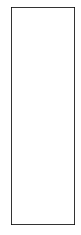

In [131]:
images, labels = next(iter(dl_train))

def show_images(images, labels, preds):
    plt.figure(figsize=(8, 4))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        image = image.unsqueeze(0)
        logps = model_ft(image)
        ps = torch.exp(logps)
        pred = np.argmax(ps.cpu().detach())
        W = model_ft.features.denseblock4.denselayer16.conv2.weight
        w = W[pred,:]
        cam = np.dot(out_features.detach(),w.detach().cpu())
        #print("cam: ", cam)
        print(out_features.shape)
        print(w.shape)
        print("cam.shape: ", cam.shape)
        class_activation = ndimage.zoom(cam, zoom=(32,32), order=1)
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image, cmap = 'jet', alpha=1)
        plt.imshow(class_activation, cmap='jet',alpha=0.5)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'        
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()
outputs = model_ft(images)
_, preds = torch.max(outputs, 1)
show_images(images, labels, preds)

In [119]:
for i, image in enumerate(images):
  print(image.shape)
  image = image.unsqueeze(0)
  print(image.shape)
  logps = model_ft(image)

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
